In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

import sys
sys.path.append("..")

from data import utils
from data import load_raw_data

/work/ariyanzarei/SorghumSegmentation/TreePartNet/pointnet2_ops_lib/pointnet2_ops/pointnet2_utils.py:15: UserWarning: Unable to load pointnet2_ops cpp extension. JIT Compiling.
  warnings.warn("Unable to load pointnet2_ops cpp extension. JIT Compiling.")


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


WARNING - 2022-11-07 00:19:08,938 - _axes - *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
WARNING - 2022-11-07 00:19:08,941 - _axes - *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


0.0 1.1021552936542611


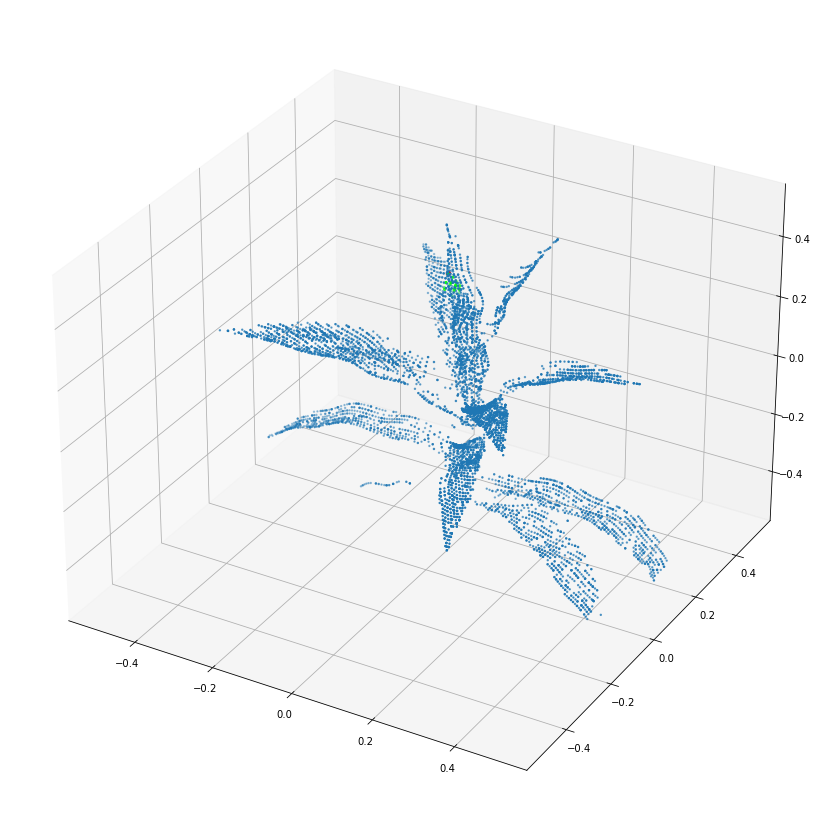

In [8]:
pcd = load_raw_data.load_pcd_plyfile_new_approach("/space/ariyanzarei/sorghum_segmentation/dataset/synthetic/2022-11-06/PointCloud/S11_31.ply", True, std_coef=0.2)
points = pcd['points']
labels = pcd['labels'].squeeze()

maxs = np.max(points,0)

ind = np.where(points[:,2] == maxs[2])[0][0]

points = torch.from_numpy(points).type(torch.DoubleTensor).unsqueeze(0)

mins, _ = torch.min(points, axis=1)
maxs, _ = torch.max(points, axis=1)
mins = mins.unsqueeze(1)
maxs = maxs.unsqueeze(1)
points = (points - mins) / (maxs - mins) - 0.5

points = points.squeeze()
distance = torch.cdist(points, points).numpy()

print(min(distance[ind]),max(distance[ind]))

close_points = np.where(distance[ind]<0.1)
far_points = np.where(distance[ind]>=0.1)
distance_colors = distance[ind]

d_colors = utils.distinct_colors(len(set(labels.tolist())))
colors = np.zeros((labels.shape[0], 3))
for i, l in enumerate(list(set(labels.tolist()))):
    colors[labels == l, :] = d_colors[i]

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection='3d')
ax.scatter(points[far_points,0],points[far_points,1],points[far_points,2], s=2)
ax.scatter(points[ind,0],points[ind,1],points[ind,2], s=20, c=(1,0,0))
ax.scatter(points[close_points,0],points[close_points,1],points[close_points,2], s=5, c=(0,1,0))
# ax.scatter(points[:,2],points[:,0],points[:,1], s=5, c=distance_colors)
plt.show()
